In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import time
import json
import os
from tqdm.auto import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cpu


In [ ]:

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_data = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
test_data  = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader  = DataLoader(test_data, batch_size=128, shuffle=False)

print("Train samples:", len(train_data))
print("Test samples:", len(test_data))


Train samples: 50000
Test samples: 10000


In [ ]:

class CNN(nn.Module):
    def __init__(self, activation):
        super(CNN, self).__init__()

        # choose activation
        if activation == "relu":
            self.act = nn.ReLU()
        elif activation == "elu":
            self.act = nn.ELU(alpha=1.0)
        elif activation == "celu":
            self.act = nn.CELU(alpha=1.0)
        else:
            raise ValueError("Unknown activation:", activation)

        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # compute flattened size automatically
        with torch.no_grad():
            dummy = torch.zeros(1, 3, 32, 32)
            out = self.pool(self.act(self.conv2(self.act(self.conv1(dummy)))))
            self.flat_dim = out.numel()

        self.fc1 = nn.Linear(self.flat_dim, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.act(self.conv1(x))
        x = self.pool(self.act(self.conv2(x)))
        x = x.view(x.size(0), -1)  # auto reshape
        x = self.act(self.fc1(x))
        x = self.fc2(x)
        return x


In [ ]:

def train(model, loader, optimizer, criterion):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for images, labels in tqdm(loader, desc="Training"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return total_loss / len(loader), 100 * correct / total


def test(model, loader, criterion):
    model.eval()
    total_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Testing"):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return total_loss / len(loader), 100 * correct / total

In [ ]:

activations = ["relu", "elu", "celu"]
results = {}

EPOCHS = 5
criterion = nn.CrossEntropyLoss()

for act in activations:
    print("\n============================")
    print("Training with:", act.upper())
    print("============================")

    model = CNN(act).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses, test_losses = [], []
    train_accs, test_accs = [], []

    start_time = time.time()

    for epoch in tqdm(range(EPOCHS), desc=f"Activation {act.upper()} - Epochs"):
        train_loss, train_acc = train(model, train_loader, optimizer, criterion)
        test_loss, test_acc = test(model, test_loader, criterion)

        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accs.append(train_acc)
        test_accs.append(test_acc)

        print(f"Epoch {epoch+1}/{EPOCHS} | "
              f"Train Acc: {train_acc:.2f}% | Test Acc: {test_acc:.2f}%")

    end_time = time.time()
    total_time = end_time - start_time

    results[act] = {
        "train_losses": train_losses,
        "test_losses": test_losses,
        "train_accuracies": train_accs,
        "test_accuracies": test_accs,
        "training_time": total_time
    }


Training with: RELU


Activation RELU - Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/391 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 1/5 | Train Acc: 52.11% | Test Acc: 61.81%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 2/5 | Train Acc: 67.35% | Test Acc: 66.96%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 3/5 | Train Acc: 73.51% | Test Acc: 69.37%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 4/5 | Train Acc: 78.60% | Test Acc: 69.00%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 5/5 | Train Acc: 83.38% | Test Acc: 69.71%

Training with: ELU


Activation ELU - Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/391 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 1/5 | Train Acc: 54.52% | Test Acc: 63.17%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 2/5 | Train Acc: 68.95% | Test Acc: 66.92%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 3/5 | Train Acc: 76.62% | Test Acc: 68.16%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 4/5 | Train Acc: 83.31% | Test Acc: 68.09%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 5/5 | Train Acc: 89.03% | Test Acc: 68.21%

Training with: CELU


Activation CELU - Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/391 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 1/5 | Train Acc: 54.31% | Test Acc: 63.24%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 2/5 | Train Acc: 68.93% | Test Acc: 66.36%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 3/5 | Train Acc: 76.18% | Test Acc: 68.15%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 4/5 | Train Acc: 83.53% | Test Acc: 67.92%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 5/5 | Train Acc: 89.08% | Test Acc: 67.93%


In [ ]:
os.makedirs("results", exist_ok=True)

with open("results/output.json", "w") as f:
    json.dump(results, f, indent=4)

print("Saved: results/output.json")


Saved: results/output.json


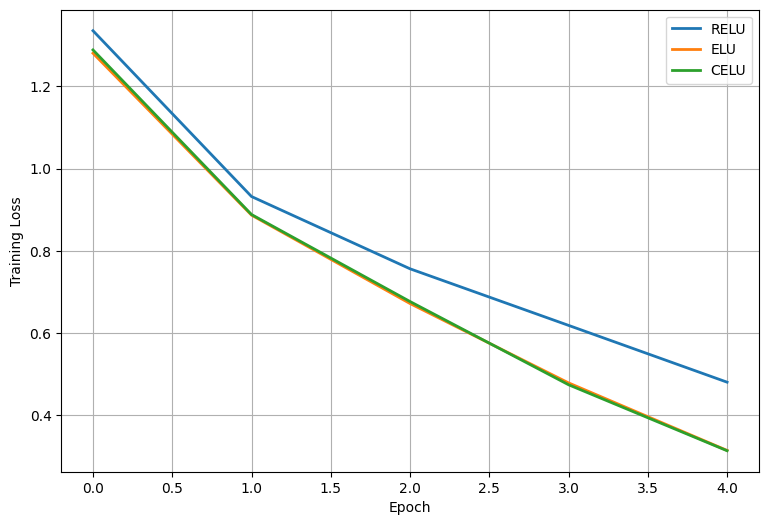

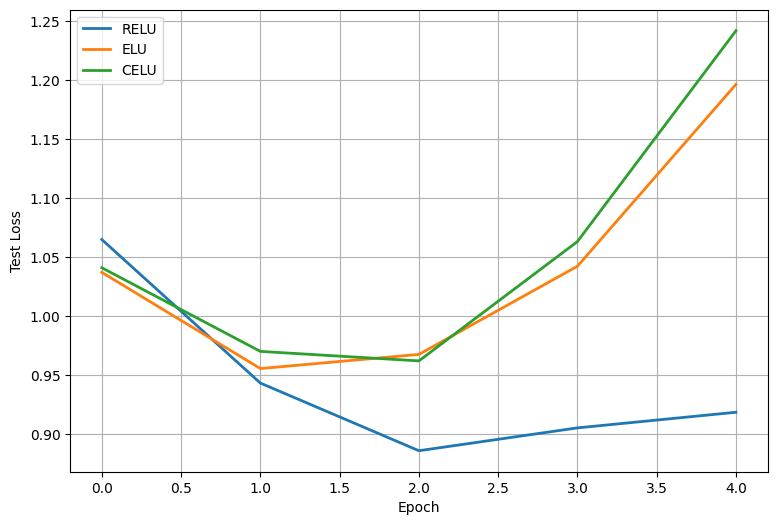

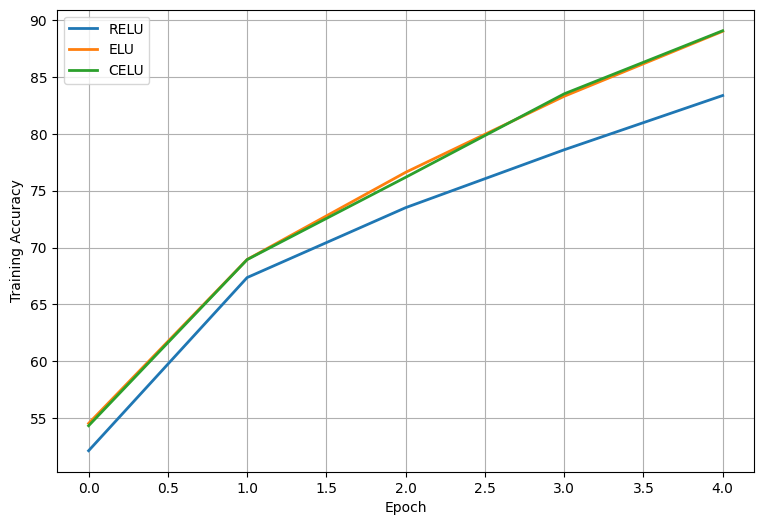

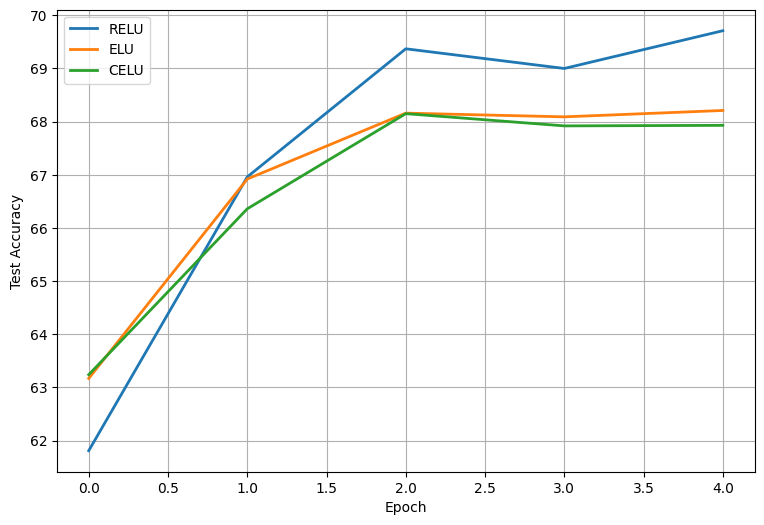

In [ ]:
def plot_metric(metric, ylabel):
    plt.figure(figsize=(9,6))
    for act in activations:
        plt.plot(results[act][metric], label=act.upper(), linewidth=2)
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.show()

plot_metric("train_losses", "Training Loss")
plot_metric("test_losses", "Test Loss")
plot_metric("train_accuracies", "Training Accuracy")
plot_metric("test_accuracies", "Test Accuracy")
